In [15]:
import os
import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib

from importlib import reload
#from sklearn.preprocessing import MinMaxScaler

import L_PINN  # python files (classes)
import pre_post
from pre_post import *
from L_PINN import *


In [16]:
def generate_circles(mean_r, num_circles, std, Nx, Ny, Nz):
    # Initialize the arrays for the radii and centers of the circles
    R0 = np.zeros(num_circles)
    X_center = np.zeros(num_circles)
    Y_center = np.zeros(num_circles)
    Z_center = np.zeros(num_circles)

    # Generate the first circle randomly
    R0[0] = np.random.normal(loc=mean_r, scale=std)
    X_center[0] = np.random.randint(R0[0], Nx-R0[0])
    Y_center[0] = np.random.randint(R0[0], Ny-R0[0])
    Z_center[0] = np.random.randint(R0[0], Nz-R0[0])

    # Loop through the remaining circles and generate them one at a time
    for i in range(1, num_circles):
        # Flag to indicate whether the new circle overlaps with any existing circles
        overlaps = True
        while overlaps:
            # Generate the radius and center of the new circle randomly
            R0[i] = np.random.normal(loc=mean_r, scale=std)
            X_center[i] = np.random.randint(R0[i], Nx-R0[i])
            Y_center[i] = np.random.randint(R0[i], Ny-R0[i])
            Z_center[i] = np.random.randint(R0[i], Nz-R0[i])

            # Check the new circle against the existing circles
            overlaps = False
            for j in range(i):
                if np.sqrt((X_center[i]-X_center[j])**2 + (Y_center[i]-Y_center[j])**2 ) < (R0[i]+R0[j]): #+ (Z_center[i]-Z_center[j])**2
                    overlaps = True
                    break
    
    return R0, X_center, Y_center, Z_center

#### Model paramters

In [17]:
   # Grid parameters
Nx=64
Ny=64
Nt=1500 
lb = np.array([0, 0,0])
ub = np.array([1, 1,1500]) 
dx = (ub[0] - lb[0]) / (Nx - 1)
dy = (ub[1] - lb[1]) / (Ny - 1)
# physical parameters
num_phases=1
dt = (ub[2] - lb[2]) / (Nt - 1)
sigma=1
mu=5e-5
delta_g= 0 
eta=7*dx

x = np.linspace(lb[0], ub[0], Nx)
y = np.linspace(lb[1], ub[1], Ny)
t= np.linspace(lb[2], ub[2], Nt) 
X, Y, T = np.meshgrid(np.linspace(lb[0], ub[0], Nx),
                        np.linspace(lb[1], ub[1], Ny),
                        np.linspace(lb[2], ub[2], Nt),
                        indexing='ij')
#### Conv-LSTM hyper-parameters
input_channels=num_phases
hidden_channels = [8, 32, 64, 64]  #  number of output channels for each layer in the network.
input_kernel_size = [3, 3, 3, 3] #    kernel sizes for 3 auto-encoders and 1 conv-lstm : (4,4), (4,4), (4,4) and (3,3)
input_stride = [2, 2, 2, 1]  #  for each auto-encoder, the stride is (2,2) then it is (1,1) for the conv-lstm
input_padding = [1, 1, 1, 1]  # a standard minimum, padding of (1,1) for each architecture 
num_layers = [3, 1]  # 3 auto-enocders + 1 conv-lstm 

inter_dim=512
latent_dim=128

In [18]:
save_path="figures"
import pre_post
reload(pre_post)  # mandatory to reload content at each re-call atfer modification
from pre_post import *
Pre_Post=PrePost(X=X,T=None, lb=lb, ub=ub, Nx=Nx,Ny=Ny,dx=dx,dy=dy,x=x,y=y, eta=eta,\
        phi_true=None)

Pre_Post.EraseFile(path=os.path.join(os.getcwd(),"VAE_figs")) 

### Generate a Dataset of Initializations

In [19]:


# Define the range of radii and eta
radii_range = np.arange(25, 26.5, 0.05)* dx
eta_range = np.arange(7, 7.001, 0.05)* dx

# Generate datasets for different radii and etas
datasets = []

for radius in radii_range:
        radius = np.array([radius])  # Convert radius to numpy array
        for eta in eta_range:
                #print(radius,eta)
                R0, X_center, Y_center, Z_center = generate_circles(mean_r=radius, num_circles=1, std=0, Nx=Nx, Ny=Ny, Nz=100)
                
                X_center = np.array([Nx * dx / 2])
                Y_center = np.array([Ny * dy / 2])
                #print(R0, X_center,Y_center)
                #stop
                phi_0, X_ini_all = Pre_Post.init_micro_cir(R0, eta, X_center, Y_center, Z_center, Nx, Ny, x, y)
                
                phi_0 = torch.tensor(phi_0, dtype=torch.float32).unsqueeze(0).unsqueeze(0)
                #print(phi_0.shape)
        
                # Add initial conditions to dataset
                datasets.append(phi_0)
tf.print("len(datasets)",len(datasets))
#"""

len(datasets) 30


2024-06-22 00:08:25.487842: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:268] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-06-22 00:08:25.487873: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: WS8692.zit.bam.de
2024-06-22 00:08:25.487880: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: WS8692.zit.bam.de
2024-06-22 00:08:25.487930: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 535.171.4
2024-06-22 00:08:25.487964: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 535.171.4
2024-06-22 00:08:25.487971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 535.171.4


In [20]:
datasets_dict = {'dataset_{}'.format(i): dataset for i, dataset in enumerate(datasets)}
np.savez('datasets.npz', **datasets_dict)


In [21]:
#"""
loaded_data = np.load('datasets.npz')
datasets = [loaded_data[key] for key in loaded_data.keys()]
datasets = [torch.tensor(dataset, dtype=torch.float32) for dataset in datasets]
datasets = torch.stack(datasets, dim=0)
tf.print("datasets" ,datasets.shape)
#"""

datasets torch.Size([30, 1, 1, 64, 64])


In [22]:
"""
datasets = [torch.tensor(dataset, dtype=torch.float32) for dataset in datasets]
datasets = torch.stack(datasets, dim=0)
print(datasets.shape)
IC_tensor = datasets[39000,...]
print(datasets.shape, IC_tensor.shape)
# Create a heatmap for the initial condition
plt.imshow(IC_tensor[0,0].clone().detach(), cmap='viridis', origin='lower')
plt.colorbar(label='u')
plt.xlabel('x')
plt.ylabel('y')
plt.title(r'$\phi_0$')
plt.savefig("IC_whole_solution.png")
plt.show()
"""

'\ndatasets = [torch.tensor(dataset, dtype=torch.float32) for dataset in datasets]\ndatasets = torch.stack(datasets, dim=0)\nprint(datasets.shape)\nIC_tensor = datasets[39000,...]\nprint(datasets.shape, IC_tensor.shape)\n# Create a heatmap for the initial condition\nplt.imshow(IC_tensor[0,0].clone().detach(), cmap=\'viridis\', origin=\'lower\')\nplt.colorbar(label=\'u\')\nplt.xlabel(\'x\')\nplt.ylabel(\'y\')\nplt.title(r\'$\\phi_0$\')\nplt.savefig("IC_whole_solution.png")\nplt.show()\n'

In [23]:
#"""
import numpy as np

# Define the number of rows and columns for the subplot grid
N = 3  # Number of rows
M = 4  # Number of columns

# Create a figure and axis for the subplot grid
fig, axes = plt.subplots(N, M, figsize=(12, 10))

# Generate random indices for selecting samples
num_samples = N * M
sample_indices = np.random.choice(len(datasets), num_samples, replace=False)

# Iterate over the random sample indices and plot images
for idx, ax in zip(sample_indices, axes.ravel()):
    # Extract the image from the dataset
    uv_ic_channel_0 = datasets[idx][0, 0, :, :]
    
    # Plot the image on the corresponding subplot
    ax.imshow(uv_ic_channel_0, cmap='viridis', origin='lower', extent=[0, uv_ic_channel_0.shape[1], 0, uv_ic_channel_0.shape[0]])
    ax.set_title(f'Sample {idx}')  # Set the title for the subplot
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.axis('off')  # Turn off axis

# Add a colorbar to the last subplot
#cbar = fig.colorbar(axes[0, 0].imshow(uv_ic_channel_0, cmap='viridis', origin='lower', extent=[0, uv_ic_channel_0.shape[1], 0, uv_ic_channel_0.shape[0]]), ax=axes.ravel().tolist(), shrink=0.95)
#cbar.set_label('u')  # Set the label for the colorbar

# Adjust layout
plt.tight_layout()
save_dir= os.path.join(os.getcwd(), "VAE_figs")
os.makedirs(save_dir, exist_ok=True)
plt.savefig(os.path.join(save_dir,"sample_Dataset"))
plt.close()
#"""

In [24]:
"""
import pre_post
from pre_post import *
reload(pre_post)
Pre_Post=PrePost(X=X,T=None, lb=lb, ub=ub, Nx=Nx,Ny=Ny,dx=dx,dy=dy,x=x,y=y, eta=eta,\
        phi_true=None)
"""
R0, X_center, Y_center,Z_center =\
        generate_circles(mean_r=25*dx,num_circles=1, std=0, Nx=Nx, Ny=Ny,Nz=100) #25*dx
X_center=np.array([Nx*dx/2])
Y_center=np.array([Ny*dx/2])

R0=25*dx
phi_0, X_ini_all=Pre_Post.init_micro_cir(R0,eta, X_center,Y_center, Z_center,Nx,Ny,x,y) 

phi_0 = torch.tensor(phi_0, dtype=torch.float32)
save_dir= os.path.join(os.getcwd(), "VAE_figs")
plt.savefig(os.path.join(save_dir,"phi0"))
plt.close()


In [ ]:
# %%
"""
T_ch=eta**2 /(sigma*mu)
x=x/eta
y=y/eta
t=t/T_ch 
dt =dt /T_ch 
dx=dx/eta
dy=dy/eta
R0=R0/eta
delta_g=eta*delta_g
lb[0], ub[0]=lb[0]/eta, ub[0]/eta
lb[1], ub[1]= lb[1]/eta, ub[1]/eta
lb[2], ub[2]= lb[2]/T_ch, ub[2]/T_ch
ub=ub/eta
"""


'\nT_ch=eta**2 /(sigma*mu)\nx=x/eta\ny=y/eta\nt=t/T_ch \ndt =dt /T_ch \ndx=dx/eta\ndy=dy/eta\nR0=R0/eta\ndelta_g=eta*delta_g\nlb[0], ub[0]=lb[0]/eta, ub[0]/eta\nlb[1], ub[1]= lb[1]/eta, ub[1]/eta\nlb[2], ub[2]= lb[2]/T_ch, ub[2]/T_ch\nub=ub/eta\n'

#### define the variational autoencoder 

In [ ]:
def compute_output_shape(W_in, kernel_size, stride, padding):
    W_out = (W_in - kernel_size + 2 * padding) // stride + 1
    return W_out

#  input dimensions
W_in = 64

# Encoder block 0
encoder0_kernel_size =3
encoder0_stride = 2
encoder0_padding = 1

encoder_params = [
    {"kernel_size":3, "stride": 2, "padding": 1},  # Encoder block 0 parameters
    {"kernel_size": 3, "stride": 2, "padding": 1},# Encoder block 1 parameters
    {"kernel_size": 3, "stride": 2, "padding": 1}   # Encoder block 1 parameters
]


# Iterate through encoder blocks and compute output shapes
for i, params in enumerate(encoder_params):
    W_out = compute_output_shape(W_in, params["kernel_size"], params["stride"], params["padding"])
    #tf.print("Output shape after encoder block {}:".format(i), W_out)
    
    # Update input shape for the next encoder block
    W_in = W_out

In [25]:
#"""
import L_PINN
reload(L_PINN)  # mandatory to reload content at each re-call atfer modification
from L_PINN import *

input  = phi_0.clone().detach().to(torch.float32).unsqueeze(0).unsqueeze(0)
VAE = VariationaAutoencoder( input_tensor=input,   input_channels = num_phases, # one phase 
    hidden_channels = hidden_channels,  #  number of output channels for each layer in the network.
    input_kernel_size = input_kernel_size, #    kernel sizes for 3 auto-encoders and 1 conv-lstm : (4,4), (4,4), (4,4) and (3,3)
    input_stride = input_stride,  #  for each auto-encoder, the stride is (2,2) then it is (1,1) for the conv-lstm
    input_padding = input_padding,  # a standard minimum, padding of (1,1) for each architecture 
    num_layers = num_layers,  # 3 auto-enocders + 1 conv-lstm 
    inter_dim=inter_dim,
    latent_dim=latent_dim,
    )


/home/selfetni/.local/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:28: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


#### train the variational autoencoder 

In [156]:
import L_PINN
reload(L_PINN)  # mandatory to reload content at each re-call atfer modification
from L_PINN import *
#datasets=input.unsqueeze(0)
dataloader = DataLoader(datasets, batch_size=128, shuffle=True)
VAE.train(dataloader,save_path="VAE_figs",datasets=datasets)

Epoch [1/100], Loss: 8.606e+00
Epoch [21/100], Loss: 1.124e-01
Epoch [41/100], Loss: 5.201e-02
Epoch [61/100], Loss: 2.255e-02
Epoch [81/100], Loss: 1.746e-02
VAE trained


In [158]:
VAE.check_IC(datasets,save_dir)

#### Autoencoder Inference 

In [26]:
import L_PINN
reload(L_PINN)  # mandatory to reload content at each re-call atfer modification
from L_PINN import *

num_samples = datasets.size(0)  # Update with your desired number of samples

random_index = torch.randint(0, num_samples, (1,)).item()

random_sample =  datasets[random_index]


new_VAE= VariationaAutoencoder( input_tensor=input,  input_channels = num_phases, # one phase 
    hidden_channels = hidden_channels,  #  number of output channels for each layer in the network.
    input_kernel_size = input_kernel_size, #    kernel sizes for 3 auto-encoders and 1 conv-lstm : (4,4), (4,4), (4,4) and (3,3)
    input_stride = input_stride,  #  for each auto-encoder, the stride is (2,2) then it is (1,1) for the conv-lstm
    input_padding = input_padding,  # a standard minimum, padding of (1,1) for each architecture 
    num_layers = num_layers,  # 3 auto-enocders + 1 conv-lstm 
    inter_dim=inter_dim,
    latent_dim=latent_dim,
    )

optimizer = optim.Adam(new_VAE.parameters(), lr=0.001)  
scheduler = StepLR(optimizer, step_size=100, gamma=0.97)  
checkpoint_path = 'models/VAE_checkpoint.pt'

new_VAE, optimizer, scheduler=new_VAE.load_checkpoint(optimizer, scheduler,checkpoint_path)

new_VAE.check_IC(datasets,save_dir)

Pretrained VAE model loaded!


### Autoencoder-LSTM  model 

In [49]:
import L_PINN
reload(L_PINN)  # mandatory to reload content at each re-call atfer modification
from L_PINN import *
    
if __name__ == '__main__':
    
    save_path="figures"
    Pre_Post.EraseFile(path=os.path.join(os.getcwd(),save_path))
    
    input = torch.tensor(phi_0).clone().detach().to(torch.float32).unsqueeze(0).unsqueeze(0)
    latent_representation = torch.zeros(input.shape[0], Nx, 8, 8)
    
    tf.print("input.shape: ",input.shape)

    ################# build the model #####################
    Nt=40
    Nsteps =Nt
    lb = np.array([0, 0,0])
    ub = np.array([Nx*dx, Ny*dy,Nt*dt]) 
    time_batch_size=Nt
    list_steps = list(range(0, Nsteps+1))
    
    n_iters_adam =10000 # 
    lr_adam = 5e-4 # 1e-3 
    pre_model_save_path = './models/checkpoint1000.pt'
    model_save_path = './models/checkpoint1000.pt'
    fig_save_path = './figures/'  

    import L_PINN
    reload(L_PINN)  # mandatory to reload content at each re-call atfer modification
    from L_PINN import *
    
    PINN = VAE_convLSTM(
        input_tensor=input ,
        input_channels = input_channels, # one phase 
        hidden_channels =hidden_channels,  #  number of output channels for each layer in the network.
        input_kernel_size = input_kernel_size, #    kernel sizes for 3 auto-encoders and 1 conv-lstm : (4,4), (4,4), (4,4) and (3,3)
        input_stride = input_stride,  #  for each auto-encoder, the stride is (2,2) then it is (1,1) for the conv-lstm
        input_padding = input_padding,  # a standard minimum, padding of (1,1) for each architecture 
        inter_dim = inter_dim,
        latent_dim =latent_dim,
        sigma= sigma,
        mu=mu,
        delta_g= delta_g ,
        eta=eta,
        Nx=Nx,
        Ny=Ny,
        Nt=Nt,
        dt = dt,
        dx=dx,
        lb=lb,
        ub=ub,
        num_layers = num_layers,  # M auto-enocders + N conv-lstm  
        upscale_factor = 8,  # for upscaling to the original dimension  
        Nsteps = Nsteps, 
        list_steps = list_steps,
        time_batch_size=time_batch_size
    )

    initial_state= set_initial_state(latent_representation,num_layers)  
    
    #print(PINN)
    
    PINN.encoder=new_VAE.encoder
    PINN.decoder=new_VAE.decoder
    PINN.fc1=new_VAE.fc1
    PINN.fc_mu=new_VAE.fc_mu
    PINN.fc_logvar=new_VAE.fc_logvar
    
    ################# train the model #####################
    start = time.time()
    train_loss = PINN.train(new_VAE,input, initial_state, n_iters_adam, 
        lr_adam, dt, dx, mu, sigma, eta,delta_g, model_save_path,\
        pre_model_save_path,\
            TL_Autoencoder_convLSTM=False,TL_Autoencoder=False)
    end = time.time()

input.shape:  torch.Size([1, 1, 64, 64])


/tmp/ipykernel_1134625/2018564823.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input = torch.tensor(phi_0).clone().detach().to(torch.float32).unsqueeze(0).unsqueeze(0)


Epoch 1/10000 (0.01%) - PDE Loss: 7.173e-03, VAE Loss: 2.953e+01, Original Total Loss: 2.954e+01, 


Epoch 50/10000 (0.50%) - PDE Loss: 3.108e-03, VAE Loss: 1.830e+00, Original Total Loss: 1.833e+00, 


Epoch 100/10000 (1.00%) - PDE Loss: 6.153e-04, VAE Loss: 3.514e-01, Original Total Loss: 3.520e-01, 


Epoch 150/10000 (1.50%) - PDE Loss: 4.394e-04, VAE Loss: 1.775e-01, Original Total Loss: 1.780e-01, 


Epoch 200/10000 (2.00%) - PDE Loss: 4.028e-04, VAE Loss: 1.339e-01, Original Total Loss: 1.343e-01, 


Epoch 250/10000 (2.50%) - PDE Loss: 3.951e-04, VAE Loss: 1.079e-01, Original Total Loss: 1.083e-01, 


Epoch 300/10000 (3.00%) - PDE Loss: 3.800e-04, VAE Loss: 8.774e-02, Original Total Loss: 8.812e-02, 


Epoch 350/10000 (3.50%) - PDE Loss: 3.612e-04, VAE Loss: 8.069e-02, Original Total Loss: 8.105e-02, 


Epoch 400/10000 (4.00%) - PDE Loss: 3.159e-04, VAE Loss: 6.831e-02, Original Total Loss: 6.862e-02, 


Epoch 450/10000 (4.50%) - PDE Loss: 3.056e-04, VAE Loss: 6.247e-02, Original

### Model Inference

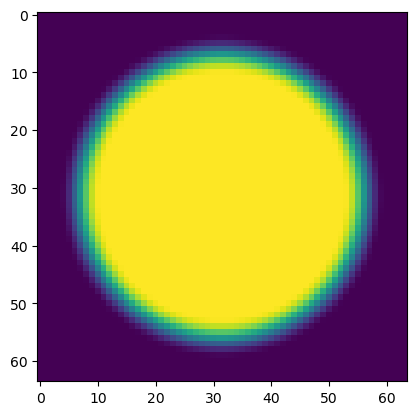

In [109]:
plt.imshow(input[0,0])
plt.show()

In [114]:
test_PINN = PINN
output, _,_ = test_PINN(initial_state, input)

In [53]:
#test_PINN

In [115]:
output_tensor = torch.cat(output[:-1], dim=0)
output_tensor.shape

torch.Size([2, 1, 64, 64])

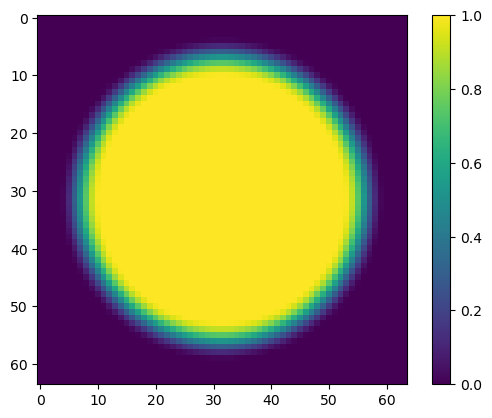

In [116]:
import matplotlib.pyplot as plt

# Assuming your tensor is named 'tensor'
tensor = torch.cat(output[:-1], dim=0)[0, 0]

# Convert tensor to a NumPy array
tensor_np = tensor.cpu().detach().numpy()

# Plot the tensor using imshow
plt.imshow(tensor_np, cmap='viridis')  # Use cmap='gray' for grayscale images
plt.colorbar()  # Add a colorbar for reference
plt.show()

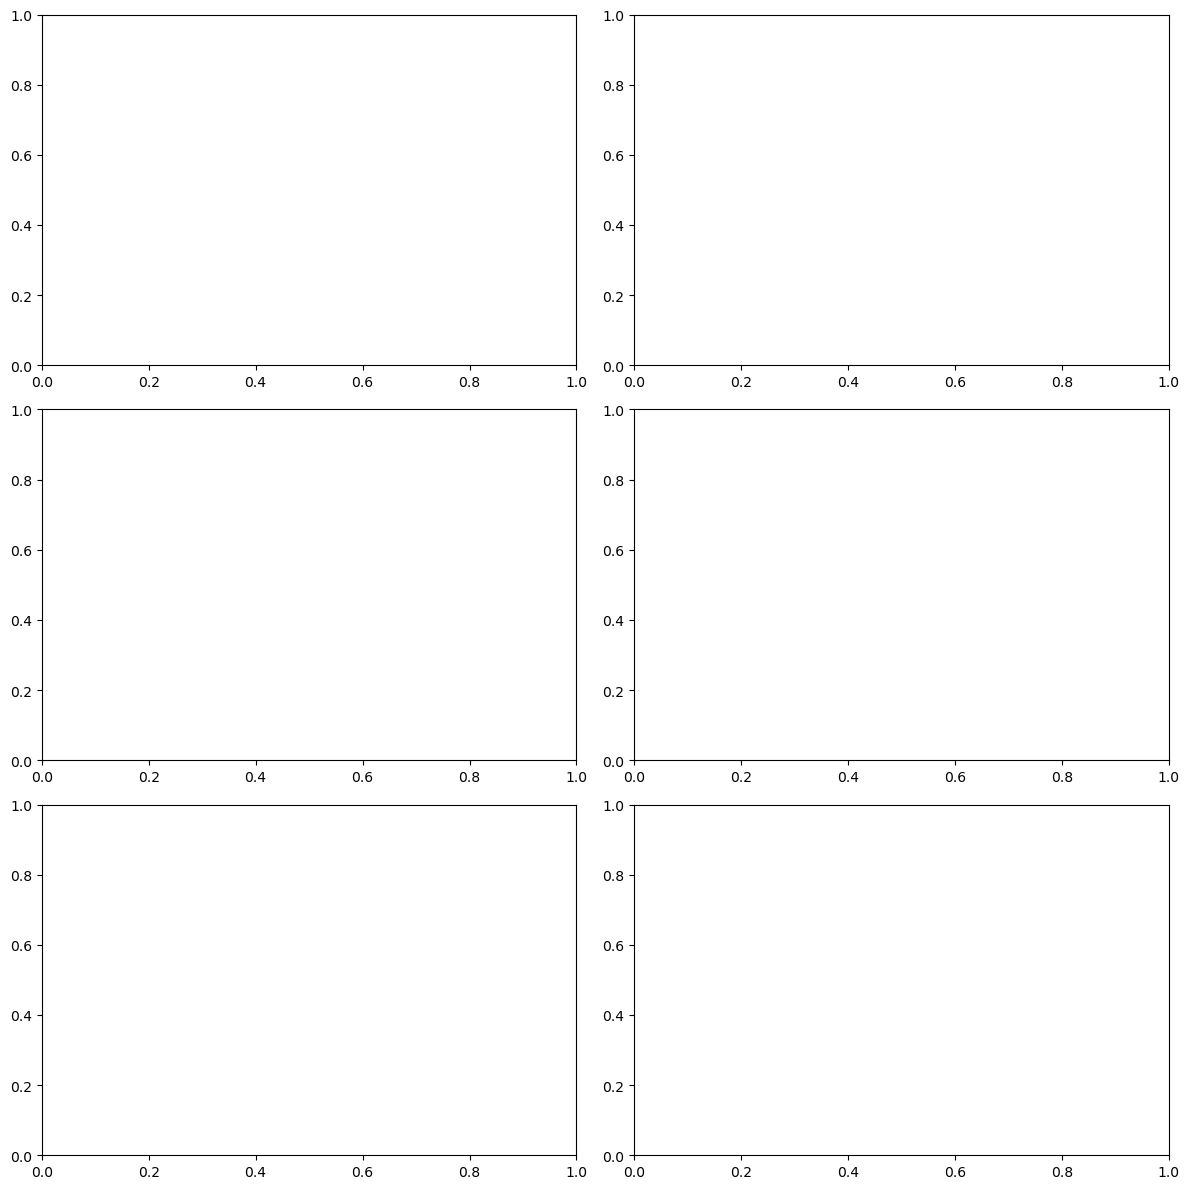

In [117]:
import matplotlib.pyplot as plt
import numpy as np

N_frames = 6


# Calculate the interval size
interval_size = len(output) // N_frames

# Create a figure and axis for plotting
fig, axes = plt.subplots(N_frames // 2, 2, figsize=(12, 12))

# Flatten axes if it's not 2D
if N_frames // 2 == 1:
    axes = [axes]

# Pre-calculate the frame indexes and sequence numbers
frame_indexes = [(i * 2 * interval_size, (i * 2 + 1) * interval_size) for i in range(N_frames // 2)]

for (start_idx, end_idx), ax_row in zip(frame_indexes, axes):
    for j, (ax, idx) in enumerate(zip(ax_row, range(start_idx, end_idx))):
        # Get images within the current interval
        images = torch.cat(output[:-1], dim=0)[idx, 0]

        # Plot images
        phase=ax.imshow(images.cpu().detach().numpy(), cmap='viridis')  # Plot the image
        ax.set_title(f"Sequence : {idx} - Time: {idx * dt:.2e}")  # Set title for the image with real time
        ax.axis('off')  # Turn off axis
        cbar = fig.colorbar(phase, ax=ax)

plt.tight_layout()
plt.show() 


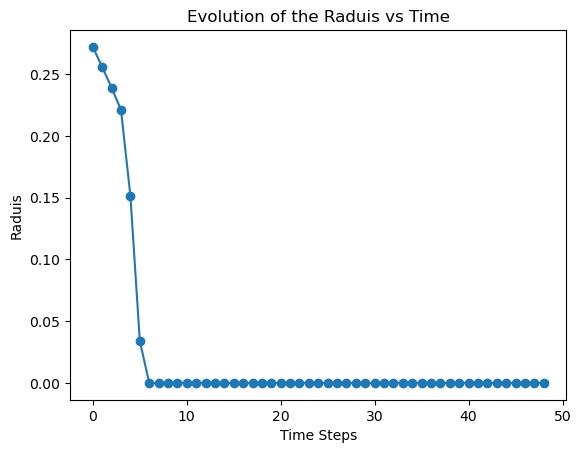

In [22]:
import matplotlib.pyplot as plt

raduis_vs_time = []

for t in range(output_tensor.size(0)):
    area = torch.sum(output_tensor[t] > 1e-2).item()
    raduis=np.sqrt(area/(Nx*Ny)/np.pi)
    raduis_vs_time.append(raduis)

plt.plot(range(len(raduis_vs_time)), raduis_vs_time, marker='o', linestyle='-')
plt.xlabel('Time Steps')
plt.ylabel('Raduis')
plt.title('Evolution of the Raduis vs Time')
#plt.grid(True)
plt.show()
